# Simple molecular dynamics simulatin by Julia
Author: Shinji Iida

In this notebook, I show a code for molecular dynamics simulation of a one-particle harmonic system. 
Suppose the following differential equation: 
$m \frac{d^2x}{dt^2} = -k(x - x_{eq})$, 
where $m$ is the mass of an oscillator, $x$ is the one dimensinoal position, $k$ is spring constant, and $x_{eq}$ is the equilibrium position of the oscilattor.
We have known the analytical solution, but here I try to solve it numerically.
To solve the differential equation, I shall use a finite difference algorithm, Velocity Verlet.

## Load library  to be used

In [1]:
using Random #for random number generation e.g., MersenneTwister()
using Plots  #for drawing a trajectory of a harmonic system and its energies.
include("systems.jl")
using .HarmonicMod

## Velocity verlet algorithm

In [2]:
function velocity_verlet(x_t::Float64, v_t::Float64, a_t::Float64, dt::Float64, system::System)
    #=
    Args:
        x: cooridnates
        v: velocities
        dt: time step
    Return:
        x_t, v_t, a_t
    =#  
    v_half = v_t + 0.5 * a_t * dt
    x_t    = x_t + v_half * dt
    a_t    = force(x_t, system.x_eq, system.spring_const) / system.mass 
    v_t    = v_half + 0.5 * a_t * dt

    return x_t, v_t, a_t
end


velocity_verlet (generic function with 1 method)

## Start to simulate

In [3]:
mass = 1.0
x_eq = 0.0
k    = 1.0
sys  = System(mass, k, x_eq)
##Initial
x_t   = 1.0
v_t   = 0.0 #For comparison with a circle with radius of one. We usually set this by gaussian()
a_t   = force(x_t, x_eq, k) / mass 
PE    = potential(x_t, x_eq, k)
KE    = kinetic_energy(v_t, mass)
H     = PE + KE
dt      = 0.1
n_steps = 10^2
outname = "traj.dat"

"traj.dat"

In [4]:
fout = open(outname, "w")
write(fout, "$x_t $v_t $PE $KE $H \n")
@time for i in 1:n_steps
    (x_t, v_t, a_t) = velocity_verlet(x_t, v_t, a_t, dt, sys)    
    PE    = potential(x_t, x_eq, k)
    KE    = kinetic_energy(v_t, mass)
    write(fout, "$x_t $v_t $PE $KE $H \n")
end
close(fout)


  0.000198 seconds (1.90 k allocations: 246.906 KiB)


In [5]:
# Make a function that executes the main loop

In [9]:
function simulate(x_t, v_t, a_t, dt, sys, n_steps, outname)
    fout = open(outname, "w")
    #write(fout, "$x_t $v_t $PE $KE $H \n")
    
    for i in 1:n_steps
        (x_t, v_t, a_t) = velocity_verlet(x_t, v_t, a_t, dt, sys)    
        PE    = potential(x_t, x_eq, k)
        KE    = kinetic_energy(v_t, mass)
        write(fout, "$x_t $v_t $PE $KE $H \n")
    end
    close(fout)
end
@time simulate(x_t, v_t, a_t, dt, sys, n_steps, outname)

  0.034055 seconds (54.55 k allocations: 3.419 MiB, 94.57% compilation time)


### Check the energy conservation

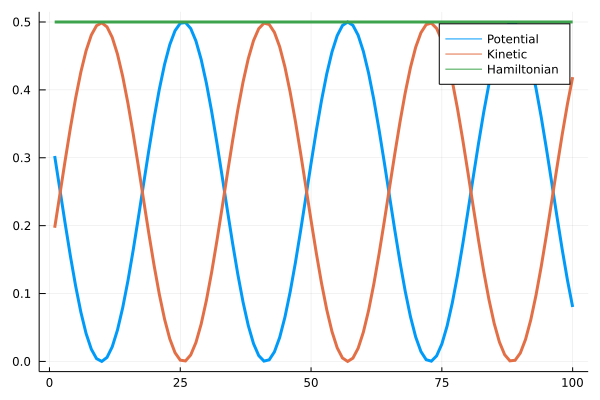

In [10]:
function draw_energy(filename)
    fin = open(filename, "r")
    ps = []
    ks = []
    hs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(ps,parse(Float64, pe))
        push!(ks,parse(Float64, ke))
        push!(hs,parse(Float64, h))
    end
    plot(1:length(ps),[ps,ks,hs], label=["Potential" "Kinetic" "Hamiltonian"], linewidth=3) #label: do not add comma!
end

draw_energy("traj.dat")

### View the phase space and compare it with a circle with radius of 1.
In my simulation, $m=1$, $k=1$ is assumed, and hence the resultant trajectory must follow the circule $\frac{1}{2}v^2 + \frac{1}{2}(x - x_{\mathrm{eq}})^2 = H$. 
Since we set 
$v_0 = 0$, 
$x_0 = 1$, 
$x_{\mathrm{eq}} = 0$
, we get $H=0.5$ (as shown above).
Therefore, we expect the trajectory to trace $\frac{1}{2}v^2 + \frac{1}{2}x^2 = 0.5 \Rightarrow v^2 + x^2 = 1$.
Let's see if we can get it.

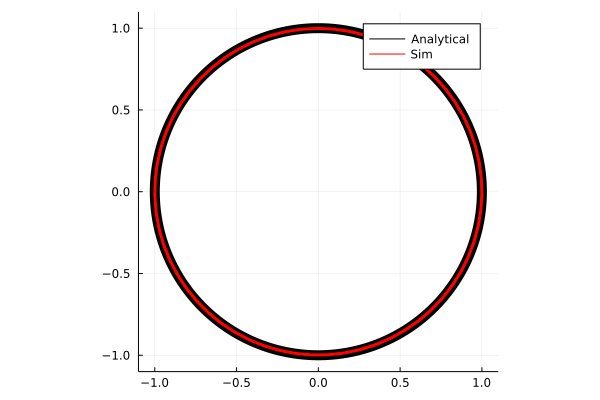

In [6]:
function get_traj(filename)
    fin = open(filename, "r")
    xs = []
    vs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(xs,parse(Float64, x))
        push!(vs,parse(Float64, v))
    end
    return xs, vs
end

function circuleShape(h, k, r)
    # (r*sinθ)^2 + (r*cosθ)^2 
    θ = LinRange(0, 2π, 500)
    (h .+ r*sin.(θ), k .+r*cos.(θ))
end
xs, vs = get_traj("traj.dat")

xlims = (-1.1,1.1)
ylims = (-1.1,1.1)

p1 = plot(circuleShape(0,0,1),xlims = xlims, ylims = ylims,c = :red, lw = 10, 
    linecolor = :black, label = "Analytical", fillalpha = 0.0, aspect_ratio = 1)

p2 = plot!((xs, vs), xlims = xlims, ylims = ylims, c = :red, lw = 3., 
    linecolor = :red, label = "Sim", fillalpha = 0.2, aspect_ratio = 1)
#plot(p1, p2)